Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from math import sqrt
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns


%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100


Load dataset

In [2]:
df = pd.read_csv('compressed_dataset.csv')

# clean NaN values and drop Unname column
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.drop(df.filter(regex="Unname"), axis=1, inplace=True)
df.dropna(how="any", inplace=True)
df.sort_values(["customer_id", "event_id", "viewer_id", "timestamp"],
               ascending=[True, True, True, True], inplace=True)

# convert unix timestamp to minutes
df["timestamp"] = df["timestamp"].apply(
    lambda x: datetime.datetime.fromtimestamp(x / 1e3).replace(second=0, microsecond=0))

print(df.head())


                   timestamp  customer_id  event_id  viewer_id  city_id  \
16991431 2022-03-11 09:59:00          0.0       0.0      151.0      0.0   
4625752  2022-03-11 10:00:00          0.0       0.0      151.0      0.0   
7406780  2022-03-11 10:00:00          0.0       0.0      151.0      0.0   
16477320 2022-03-11 10:01:00          0.0       0.0      151.0      0.0   
9161461  2022-03-11 10:01:00          0.0       0.0      151.0      0.0   

          country_id viewer_type       qoe  engagement  buffer_ms  
16991431         0.0         WFO  0.999994         0.0        242  
4625752          0.0         WFO  1.000000         0.0          0  
7406780          0.0         WFO  1.000000         0.0          0  
16477320         0.0         WFO  1.000000         0.0          0  
9161461          0.0         WFO  1.000000         0.0          0  


Cleanup

In [3]:
cleanup_condition = df.groupby(["event_id", "viewer_id"])[["timestamp"]].max(
) - df.groupby(["event_id", "viewer_id"])[["timestamp"]].min()

cleanup_condition = (cleanup_condition["timestamp"] < pd.Timedelta(
    1, unit="m")).to_frame("condition").reset_index()

df = df.merge(cleanup_condition, on=["event_id", "viewer_id"])

df.drop(df[df["condition"]].index, inplace=True)
df.drop(["condition"], axis=1, inplace=True)


Get events and event dates

In [4]:
df2 = df.copy()

df2["timestamp"] = df2["timestamp"].apply(
    lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

df2 = df2.groupby(["customer_id"])[
    ["event_id", "timestamp"]].value_counts(sort=False).to_frame("count").reset_index()

df2.sort_values(by=["event_id"], inplace=True)
df2.drop(["count"], axis=1, inplace=True)

df2.drop_duplicates("event_id", inplace=True)

df2.sort_index(inplace=True)

print(df2.head())

   customer_id  event_id  timestamp
0          0.0       0.0 2022-03-11
1          0.0       1.0 2021-12-03
2          0.0       3.0 2022-02-17
3          0.0       5.0 2021-12-10
4          0.0      24.0 2021-12-16


Get engagement and qoe score for each event

In [5]:
def f(df, target):

    count = df.groupby(["event_id"])[["timestamp"]].value_counts(
        sort=False).to_frame("count")["count"]
    eng_sum = df.groupby(["event_id", "timestamp"])[
        [target]].sum()[target]
    event_dur = (df.groupby(["event_id"])["timestamp"].max(
    ) - df.groupby(["event_id"])["timestamp"].min()).to_frame("duration")

    event_dur["duration"] = event_dur["duration"].apply(
        lambda x: int(x.total_seconds() / 60))

    inner_sum = (eng_sum / count).to_frame("inner_sum")
    outer_sum = inner_sum.groupby(["event_id"])["inner_sum"].sum()

    final = (outer_sum / event_dur["duration"]).to_frame("final")

    groupby_object = df.groupby(["customer_id"])[
        ["event_id"]].value_counts(sort=False).to_frame("count").reset_index()

    groupby_object.sort_values(by=["event_id"], inplace=True)

    groupby_object["final"] = final["final"].to_numpy()

    groupby_object.drop(["count"], axis=1, inplace=True)

    per_customer = groupby_object.drop(["event_id"], axis=1)

    per_customer.sort_index(inplace=True)

    return per_customer

eng_per_customer = f(df, "engagement")
qoe_per_customer = f(df, "qoe")

df2 = pd.DataFrame({
    "customer_id": eng_per_customer["customer_id"].to_numpy(),
    "event_id": df2["event_id"].to_numpy(),
    "datetime": df2["timestamp"].to_numpy(),
    "engagement": eng_per_customer["final"].to_numpy(),
    "qoe": qoe_per_customer["final"].to_numpy(),
})

print(df2.head())


   customer_id  event_id   datetime  engagement       qoe
0          0.0       0.0 2022-03-11    0.392381  0.994813
1          0.0       1.0 2021-12-03    0.396416  1.000260
2          0.0       3.0 2022-02-17    0.302476  1.002231
3          0.0       5.0 2021-12-10    0.281329  1.005223
4          0.0      24.0 2021-12-16    0.283329  1.003516


Subset selection

    customer_id  count
0           0.0     14
29         29.0     15
13         13.0     15
5           5.0     17
31         31.0     19


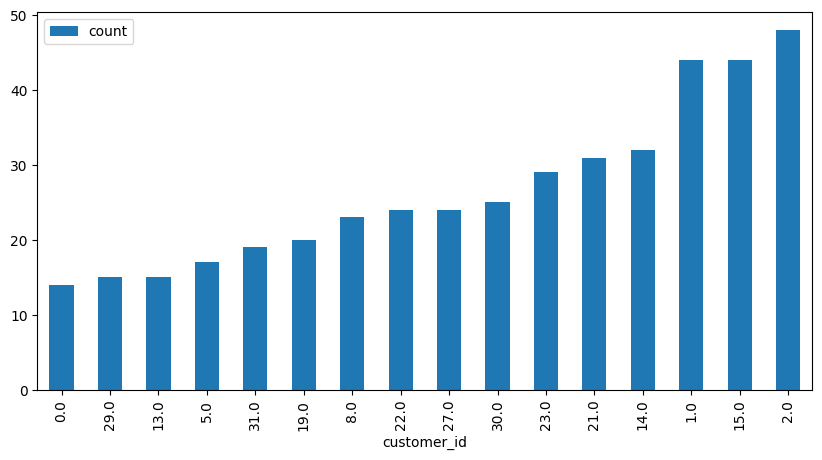

In [6]:
df3 = df2.groupby(["customer_id"])[
    "event_id"].count().to_frame("count").reset_index()

df3 = df3.sample(frac=0.5, weights=df3["count"]).sort_values(
    ["count"], ascending=True)
df3.plot.bar(x="customer_id", y="count")
print(df3.head())
plt.show()


Trendlines

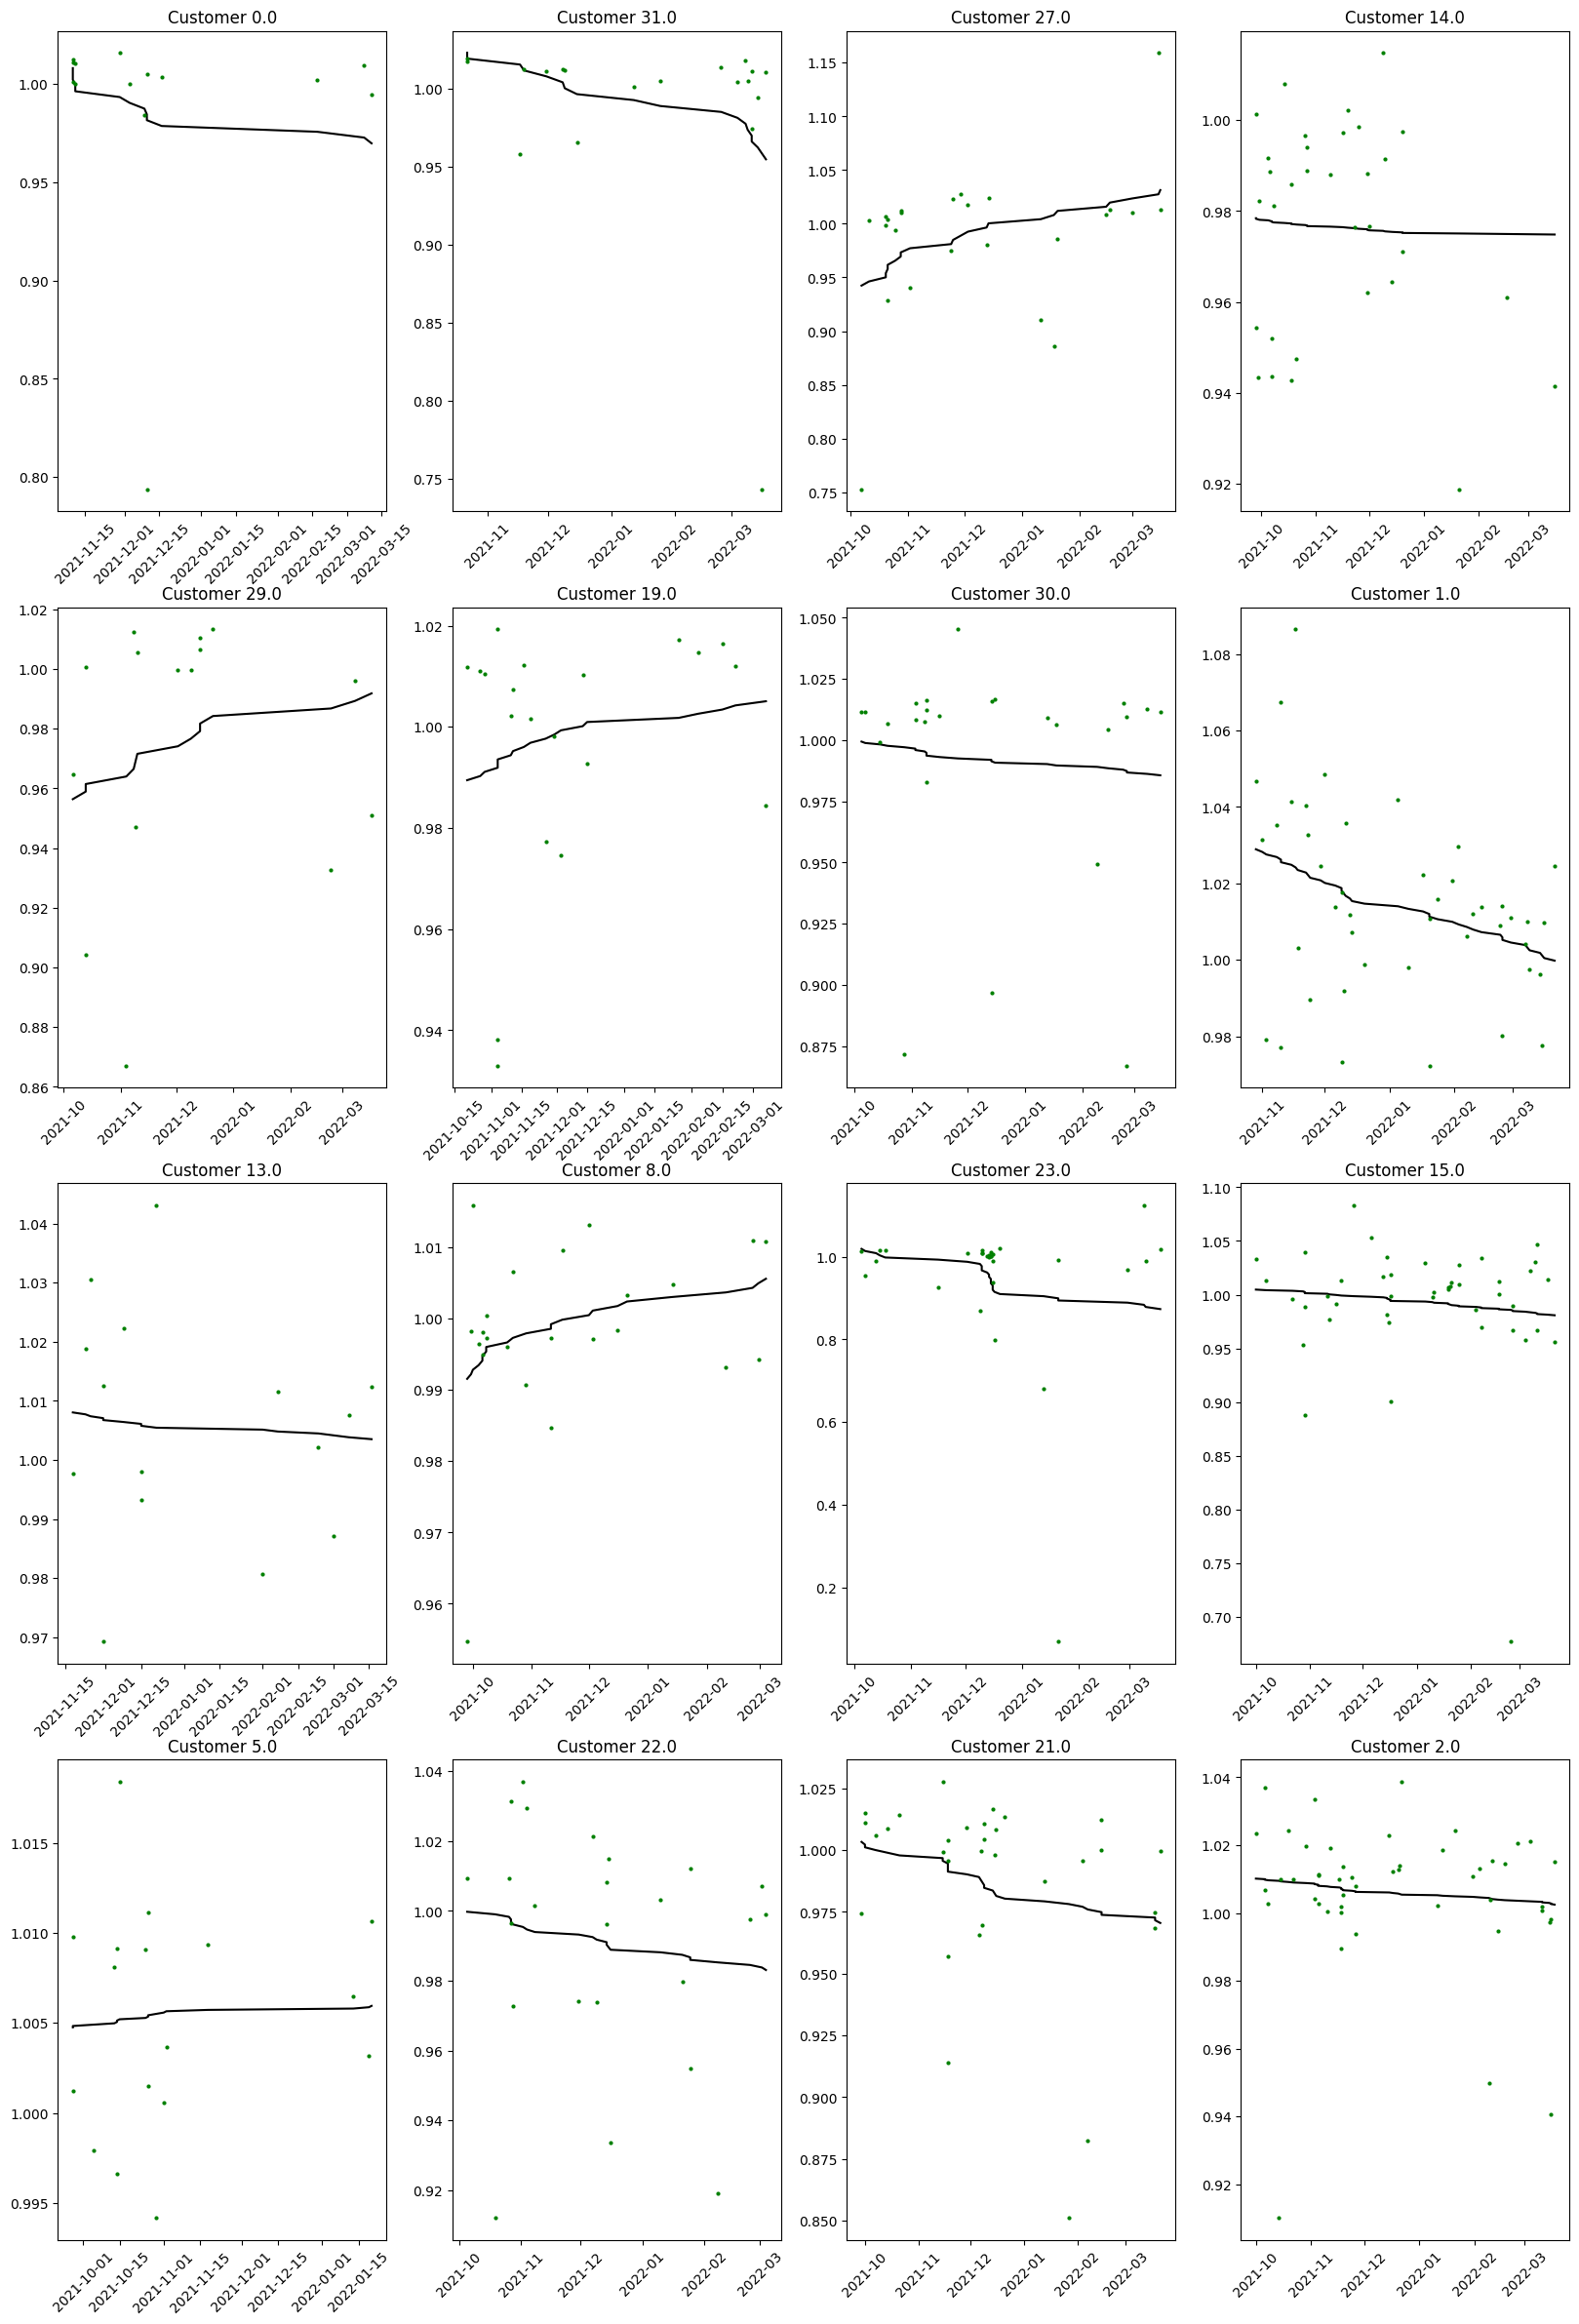

In [7]:
i, j = 0, 0

figure, axis = plt.subplots(4, 4)
figure.set_size_inches(20, 30)

for customer_id in df3["customer_id"].values:

    target_customer = df2.iloc[np.where(df2["customer_id"] == customer_id)]
    target_customer = target_customer[["datetime", "qoe"]]
    target_customer = target_customer.sort_values(by="datetime")
    target_customer["datetime"] = pd.to_datetime(target_customer["datetime"])
    target_customer = target_customer.set_index("datetime")

    x = np.arange(target_customer.index.size)
    fit = np.polyfit(x, target_customer["qoe"], 1)
    fit_fn = np.poly1d(fit)

    axis[i, j].plot(target_customer.index.to_numpy(), fit_fn(x), 'k-')
    axis[i, j].plot(target_customer.index.to_numpy(), target_customer['qoe'], 'go', ms=2)
    axis[i, j].set_title("Customer {}".format(customer_id))
    axis[i, j].xaxis.set_visible(True)
    axis[i, j].yaxis.set_visible(True)
    for tick in axis[i, j].get_xticklabels():

        tick.set_rotation(45)

    i = i + 1
    if i == 4:
        i = 0
        j = j + 1

plt.show()


QoE descrimination per month for each customer

In [8]:
df4 = df2.copy()
df4["datetime"] = pd.to_datetime(df4["datetime"])
df4 = df4.set_index("datetime")
df4 = df4.groupby(["customer_id", pd.Grouper(freq="1M")])["qoe"].mean().reset_index()
df4 = df4[~df4.isin([np.nan, np.inf, -np.inf]).any(1)]
est = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")
Xt = est.fit_transform(df4["qoe"].values.reshape(-1, 1))
Xt = Xt.flatten()
df4["descrimination"] = Xt
# string descrimination
map_dict = {0: "Bad", 1: "Poor", 2: "Average", 3: "Good", 4: "Excellent"}
df4["descrimination"] = df4["descrimination"].map(map_dict)

for customer_id in df3["customer_id"].values:

    target_customer = df4.iloc[np.where(df4["customer_id"] == customer_id)]
    target_customer = target_customer[["datetime", "descrimination"]]
    target_customer = target_customer.sort_values(by="datetime")
    target_customer["datetime"] = pd.to_datetime(target_customer["datetime"])
    target_customer = target_customer.set_index("datetime")

    print("Customer id {}".format(customer_id))
    print(target_customer, end="\n\n")

Customer id 0.0
           descrimination
datetime                 
2021-11-30      Excellent
2021-12-31        Average
2022-02-28      Excellent
2022-03-31      Excellent

Customer id 29.0
           descrimination
datetime                 
2021-10-31        Average
2021-11-30        Average
2021-12-31      Excellent
2022-02-28        Average
2022-03-31           Good

Customer id 13.0
           descrimination
datetime                 
2021-11-30      Excellent
2021-12-31      Excellent
2022-02-28      Excellent
2022-03-31      Excellent

Customer id 5.0
           descrimination
datetime                 
2021-09-30      Excellent
2021-10-31      Excellent
2021-11-30      Excellent
2022-01-31      Excellent

Customer id 31.0
           descrimination
datetime                 
2021-10-31      Excellent
2021-11-30           Good
2021-12-31      Excellent
2022-01-31      Excellent
2022-02-28      Excellent
2022-03-31           Good

Customer id 19.0
           descrimination
datetime   

Number of viewers over time that experience the QoE level

In [9]:
df5 = df.drop(["country_id", "city_id", "viewer_type",
              "buffer_ms", "engagement"], axis=1)
df5 = df5.groupby(["customer_id", "event_id", "viewer_id", "timestamp"])[
    "qoe"].mean().to_frame("qoe").reset_index()
    
est = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")
Xt = est.fit_transform(df5["qoe"].values.reshape(-1, 1))
Xt = Xt.flatten()
df5["descrimination"] = Xt
# string descrimination
map_dict = {0: "Bad", 1: "Poor", 2: "Average", 3: "Good", 4: "Excellent"}
df5["descrimination"] = df5["descrimination"].map(map_dict)
df5 = df5.groupby(["customer_id", "event_id", "timestamp", "descrimination"])[
    "viewer_id"].count().to_frame("count").reset_index()

for customer_id in df3["customer_id"].values:

    target_customer = df5.iloc[np.where(df5["customer_id"] == customer_id)]
    target_customer = target_customer[["timestamp", "descrimination"]]
    target_customer = target_customer.sort_values(by="timestamp")
    target_customer["timestamp"] = pd.to_datetime(target_customer["timestamp"])
    target_customer = target_customer.set_index("timestamp")

    print("Customer id {}".format(customer_id))
    print(target_customer, end="\n\n")


Customer id 0.0
                    descrimination
timestamp                         
2021-11-10 09:32:00        Average
2021-11-10 09:32:00      Excellent
2021-11-10 09:32:00           Good
2021-11-10 09:33:00        Average
2021-11-10 09:33:00      Excellent
...                            ...
2022-03-11 13:16:00      Excellent
2022-03-11 13:17:00           Poor
2022-03-11 13:17:00      Excellent
2022-03-11 13:18:00      Excellent
2022-03-11 13:18:00           Poor

[4861 rows x 1 columns]

Customer id 29.0
                    descrimination
timestamp                         
2021-10-06 13:59:00           Good
2021-10-06 13:59:00      Excellent
2021-10-06 14:00:00      Excellent
2021-10-06 14:01:00      Excellent
2021-10-06 14:02:00      Excellent
...                            ...
2022-03-17 22:00:00      Excellent
2022-03-17 22:01:00      Excellent
2022-03-17 22:02:00      Excellent
2022-03-17 22:03:00      Excellent
2022-03-17 22:04:00      Excellent

[1936 rows x 1 columns]

Custo

Correlation between Section 2 data points

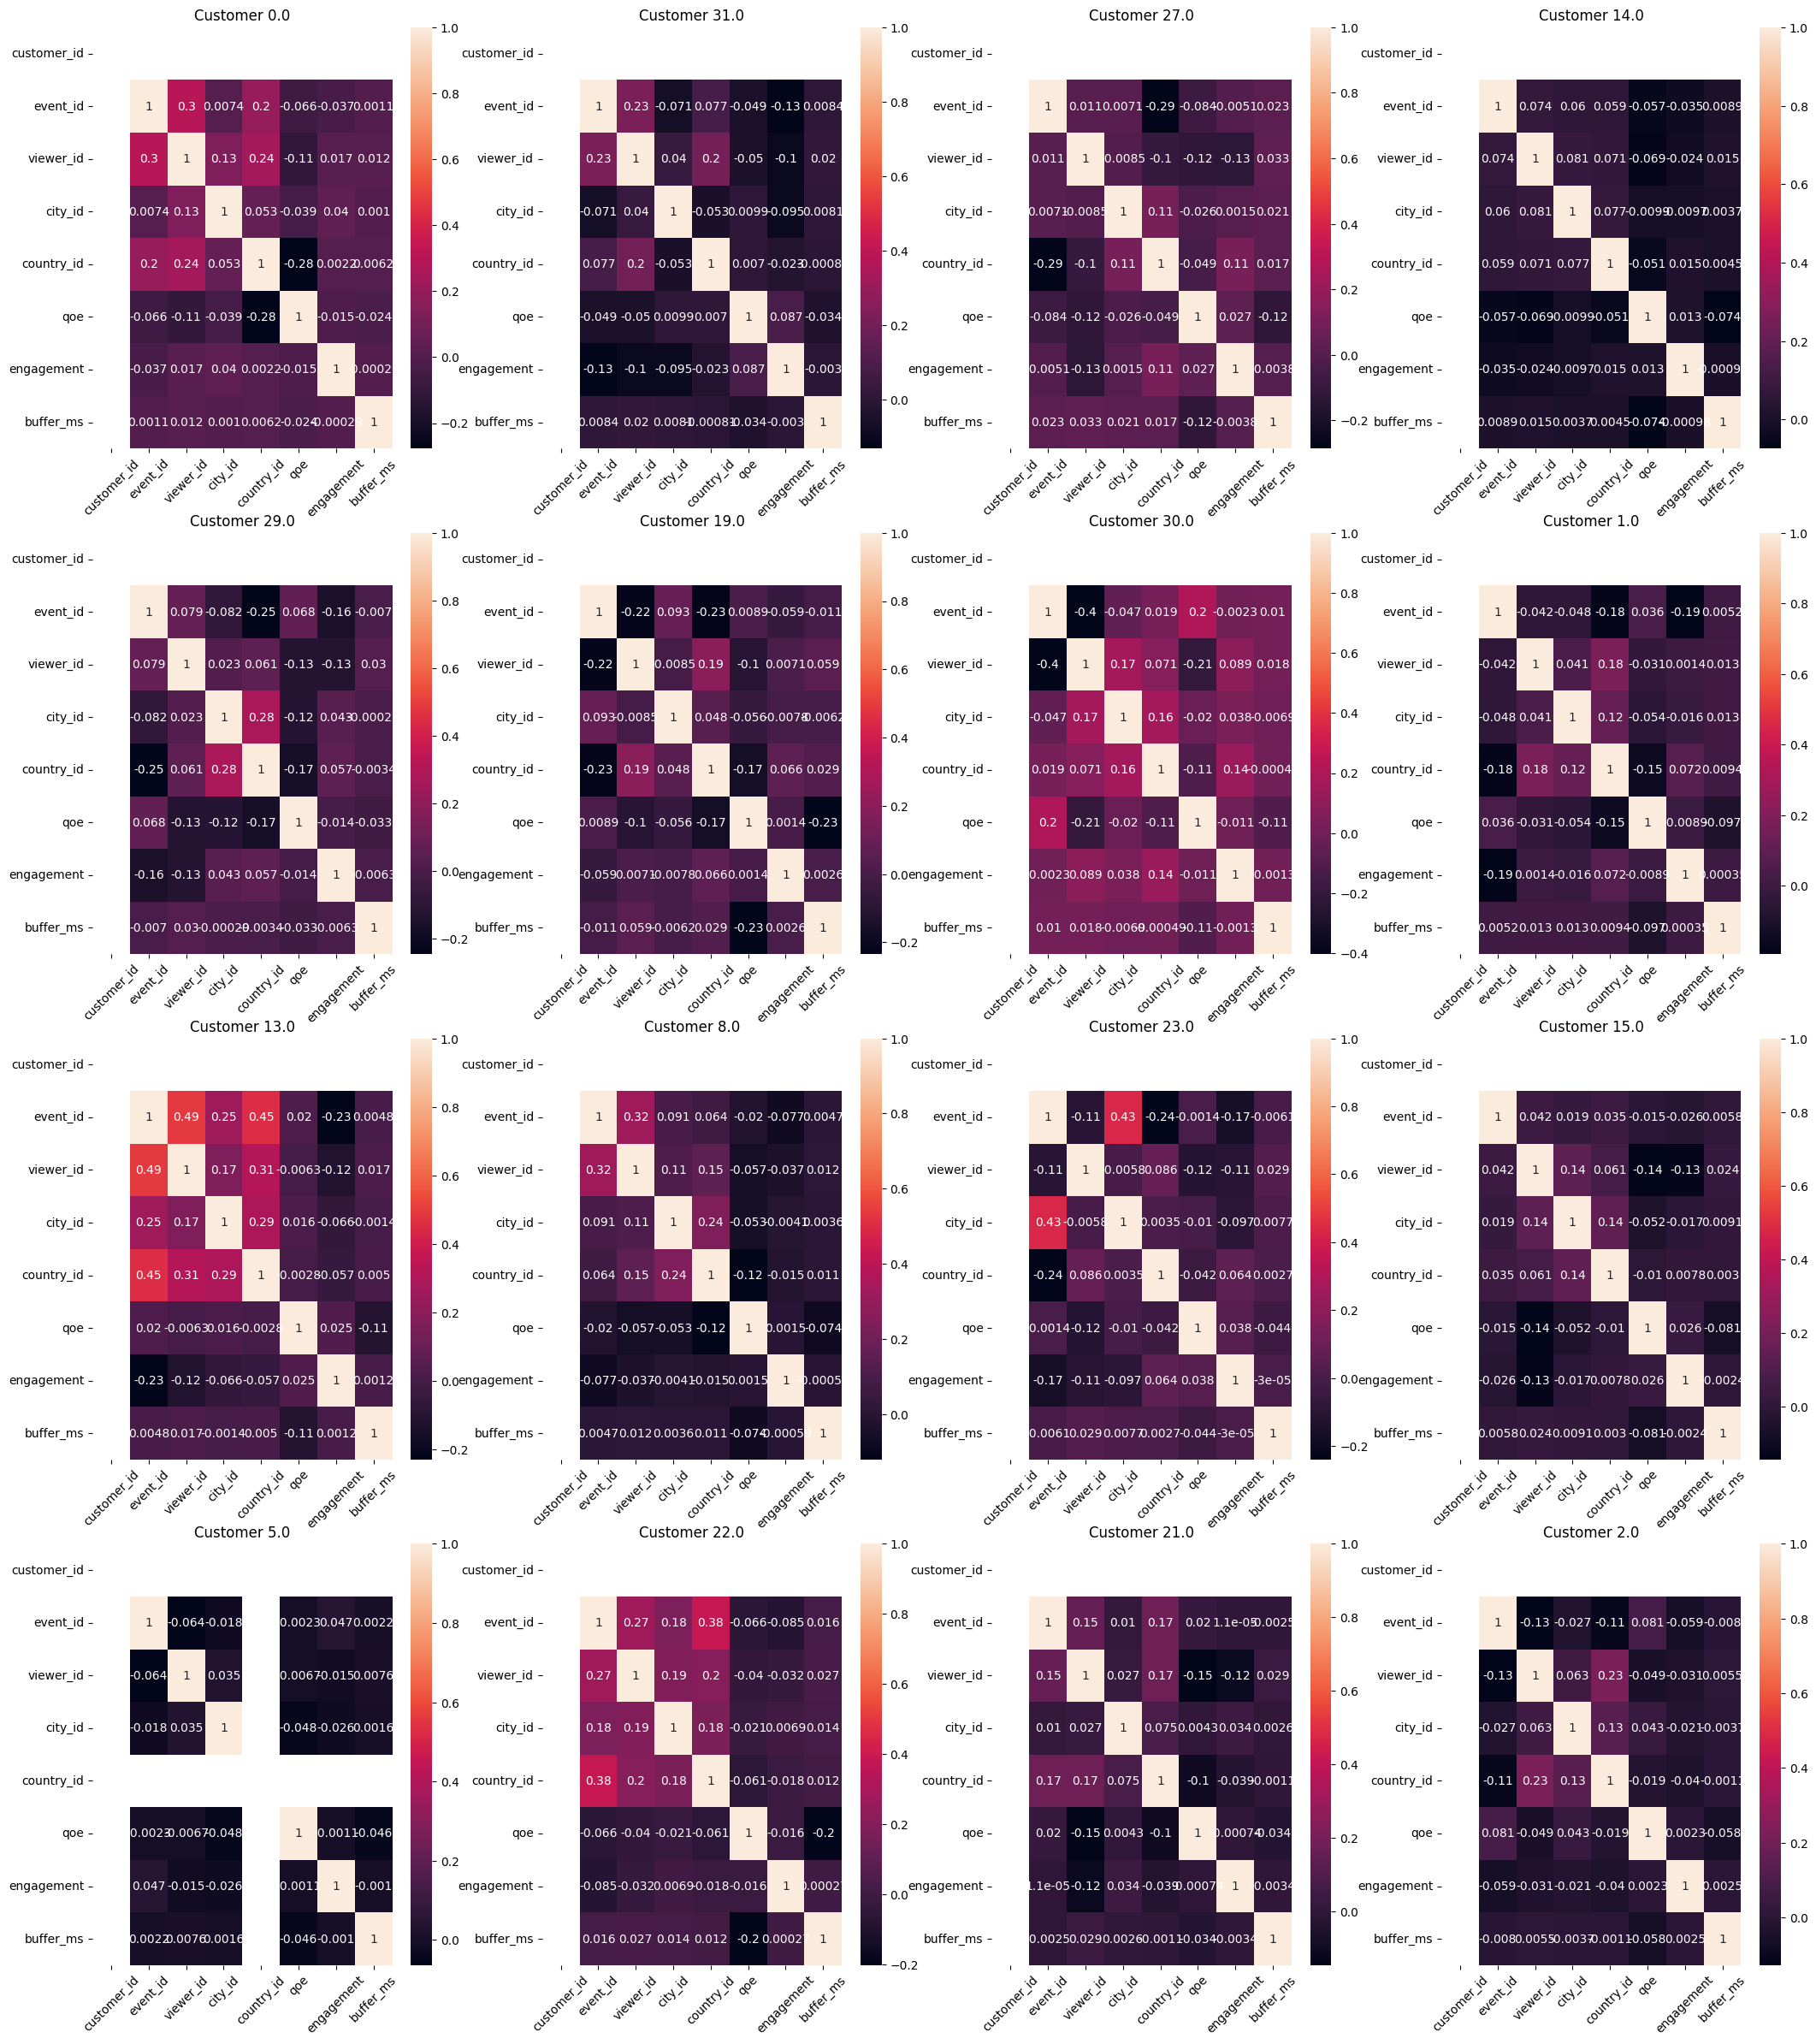

In [10]:
i, j = 0, 0

figure, axis = plt.subplots(4, 4)
figure.set_size_inches(26, 30)
for customer_id in df3["customer_id"].values:

    target_customer = df.iloc[np.where(df["customer_id"] == customer_id)]
    sns.heatmap(target_customer.corr(method="pearson"),
                annot=True, ax=axis[i, j])
    axis[i, j].set_title("Customer {}".format(customer_id))
    axis[i, j].xaxis.set_visible(True)
    axis[i, j].yaxis.set_visible(True)
    for tick in axis[i, j].get_xticklabels():

        tick.set_rotation(45)

    i = i + 1
    if i == 4:
        i = 0
        j = j + 1


Correlation between QoE number of viewer, day, duration

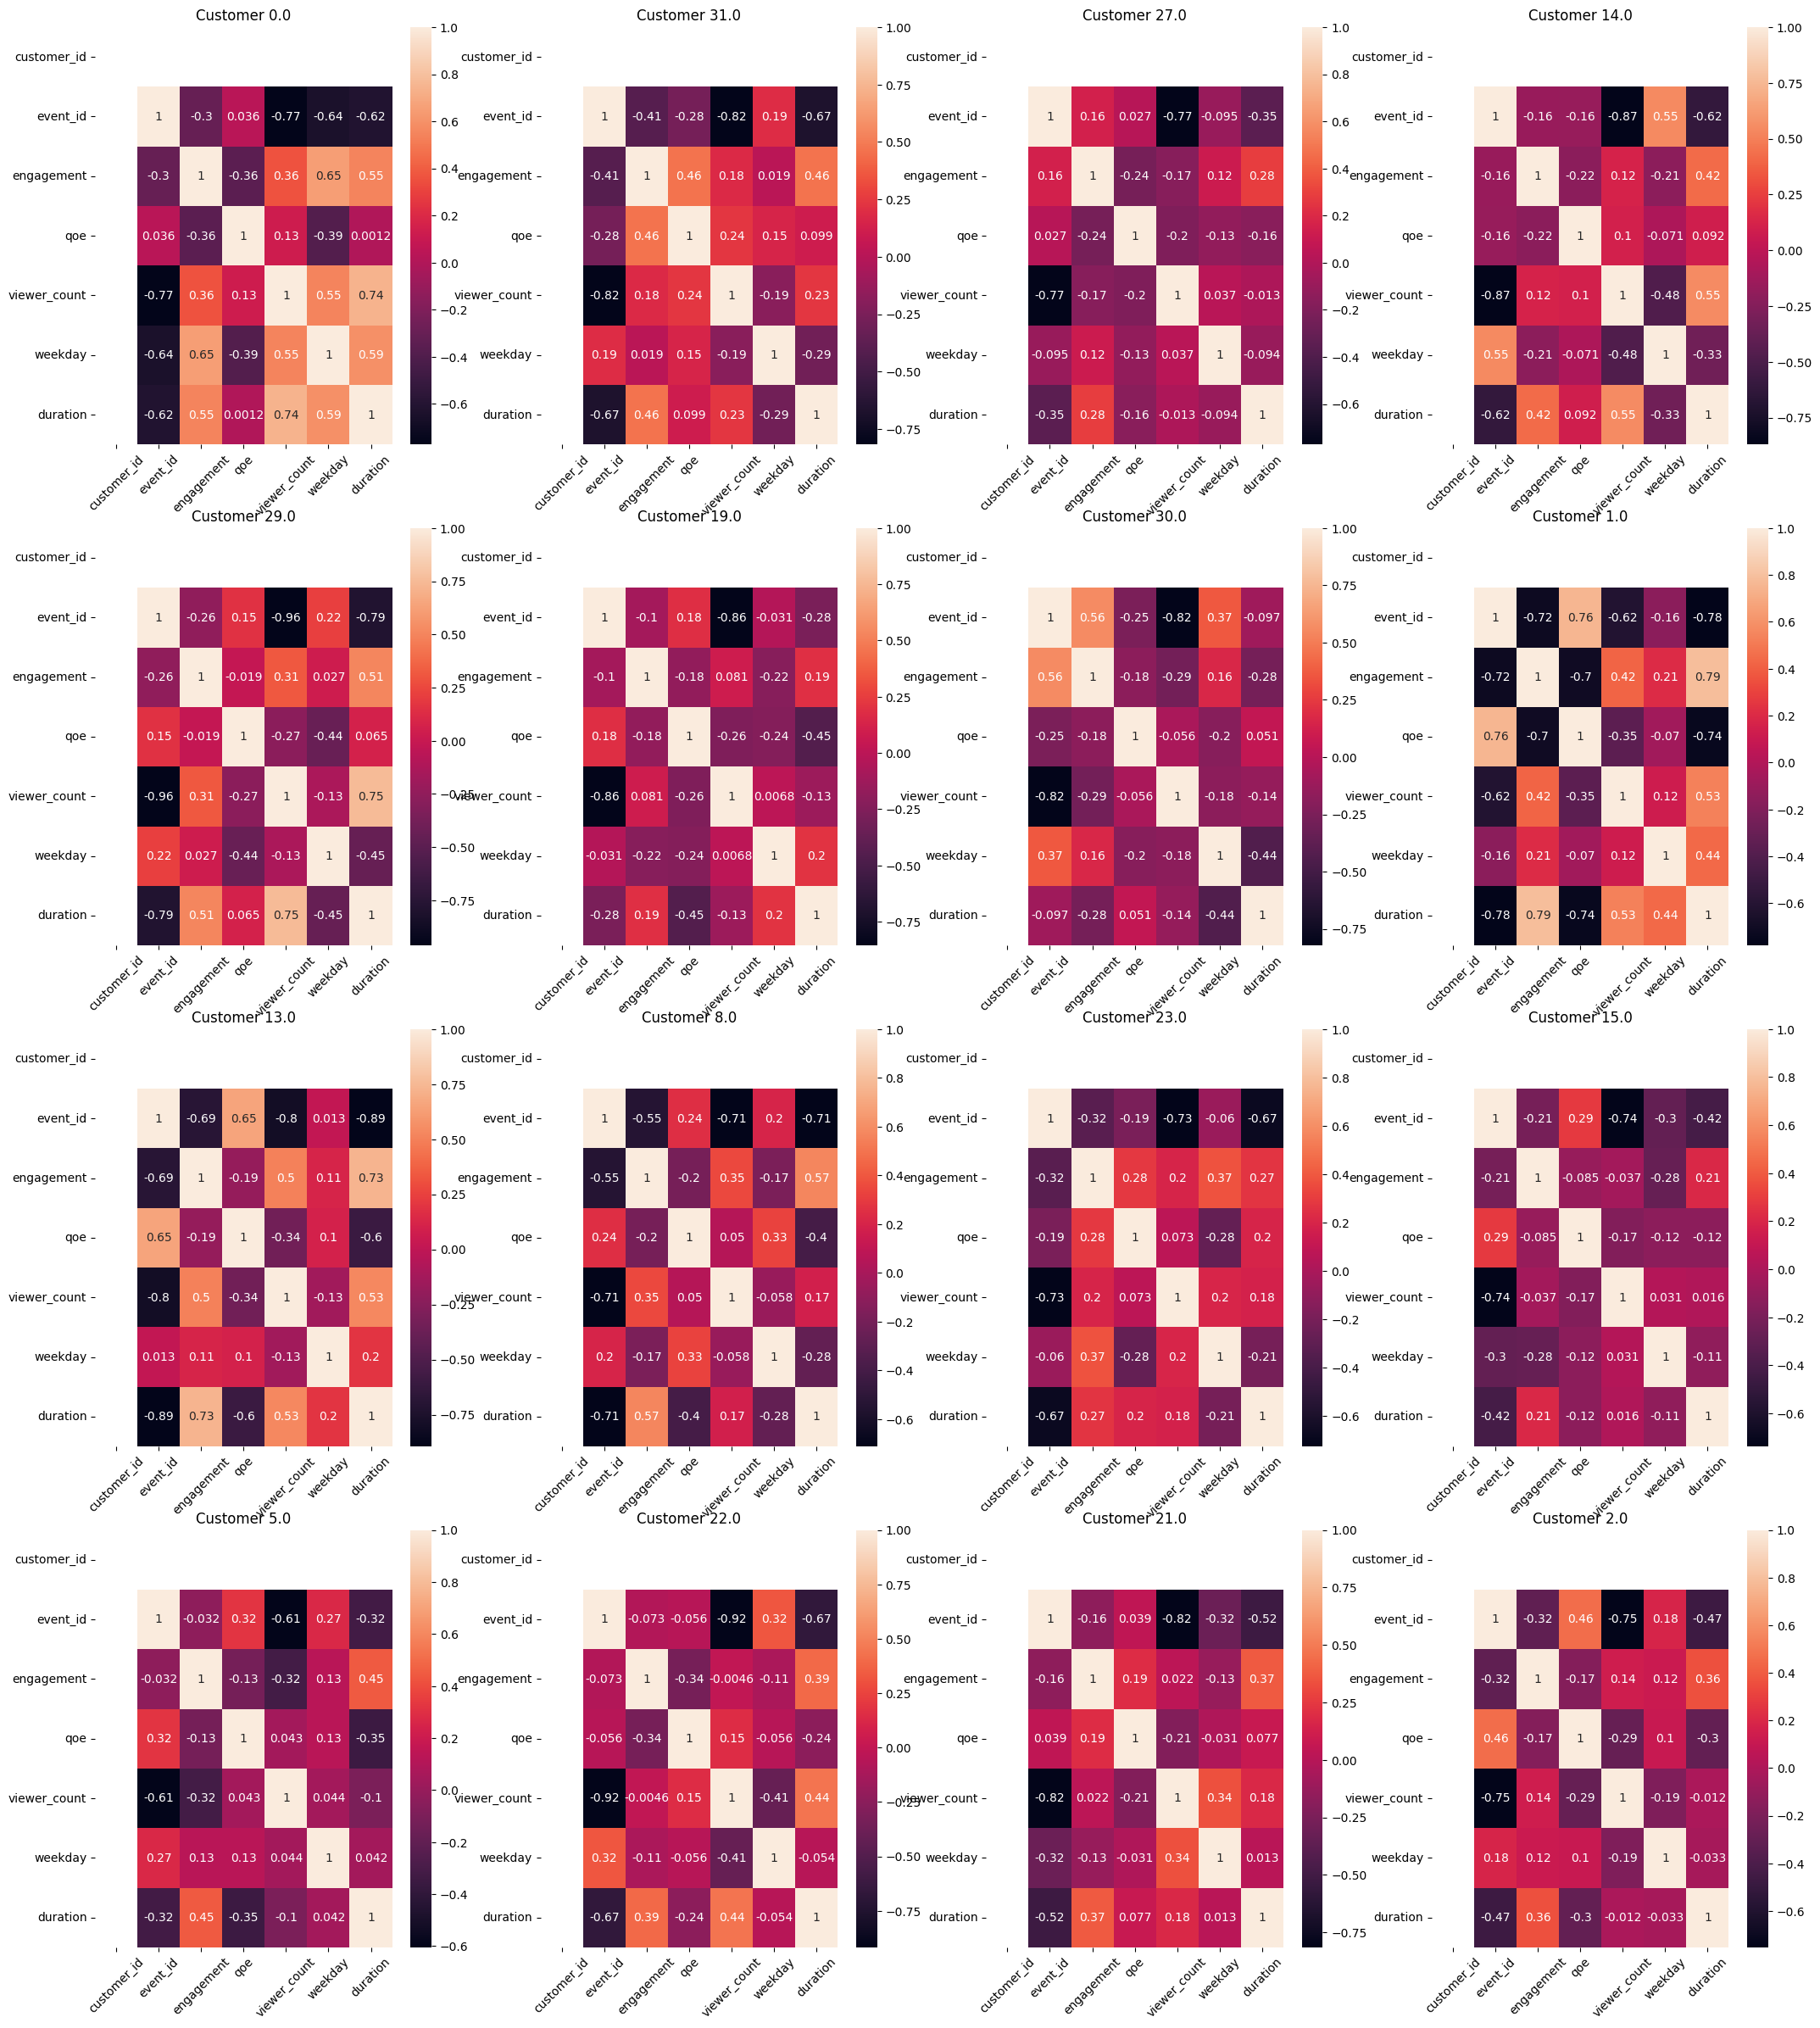

In [13]:
df6 = df.copy()

max_timestamp_df = df6.groupby(["customer_id", "event_id"])[
    "timestamp"].max().to_frame("max").reset_index()
min_timestamp_df = df6.groupby(["customer_id", "event_id"])[
    "timestamp"].min().to_frame("min").reset_index()
duration = (max_timestamp_df["max"].to_numpy() -
            min_timestamp_df["min"].to_numpy())

df6.drop_duplicates(["customer_id", "event_id", "viewer_id"], inplace=True)
df6 = df6.groupby(["customer_id", "event_id"])[
    "viewer_id"].count().to_frame("viewer_count").reset_index()

df7 = df2.copy()
df7["viewer_count"] = df6["viewer_count"]
df7["weekday"] = df7["datetime"].apply(
    lambda x: x.weekday())
df7["duration"] = duration
df7["duration"] = df7["duration"].apply(lambda x: x.total_seconds() / 60)

df7.to_csv("latest_test.csv")

i, j = 0, 0

figure, axis = plt.subplots(4, 4)
figure.set_size_inches(26, 30)
for customer_id in df3["customer_id"].values:

    target_customer = df7.iloc[np.where(df7["customer_id"] == customer_id)]
    sns.heatmap(target_customer.corr(method="pearson"),
                annot=True, ax=axis[i, j])
    axis[i, j].set_title("Customer {}".format(customer_id))
    axis[i, j].xaxis.set_visible(True)
    axis[i, j].yaxis.set_visible(True)
    for tick in axis[i, j].get_xticklabels():

        tick.set_rotation(45)

    i = i + 1
    if i == 4:
        i = 0
        j = j + 1


Correlation between QoE countries, viewers retention

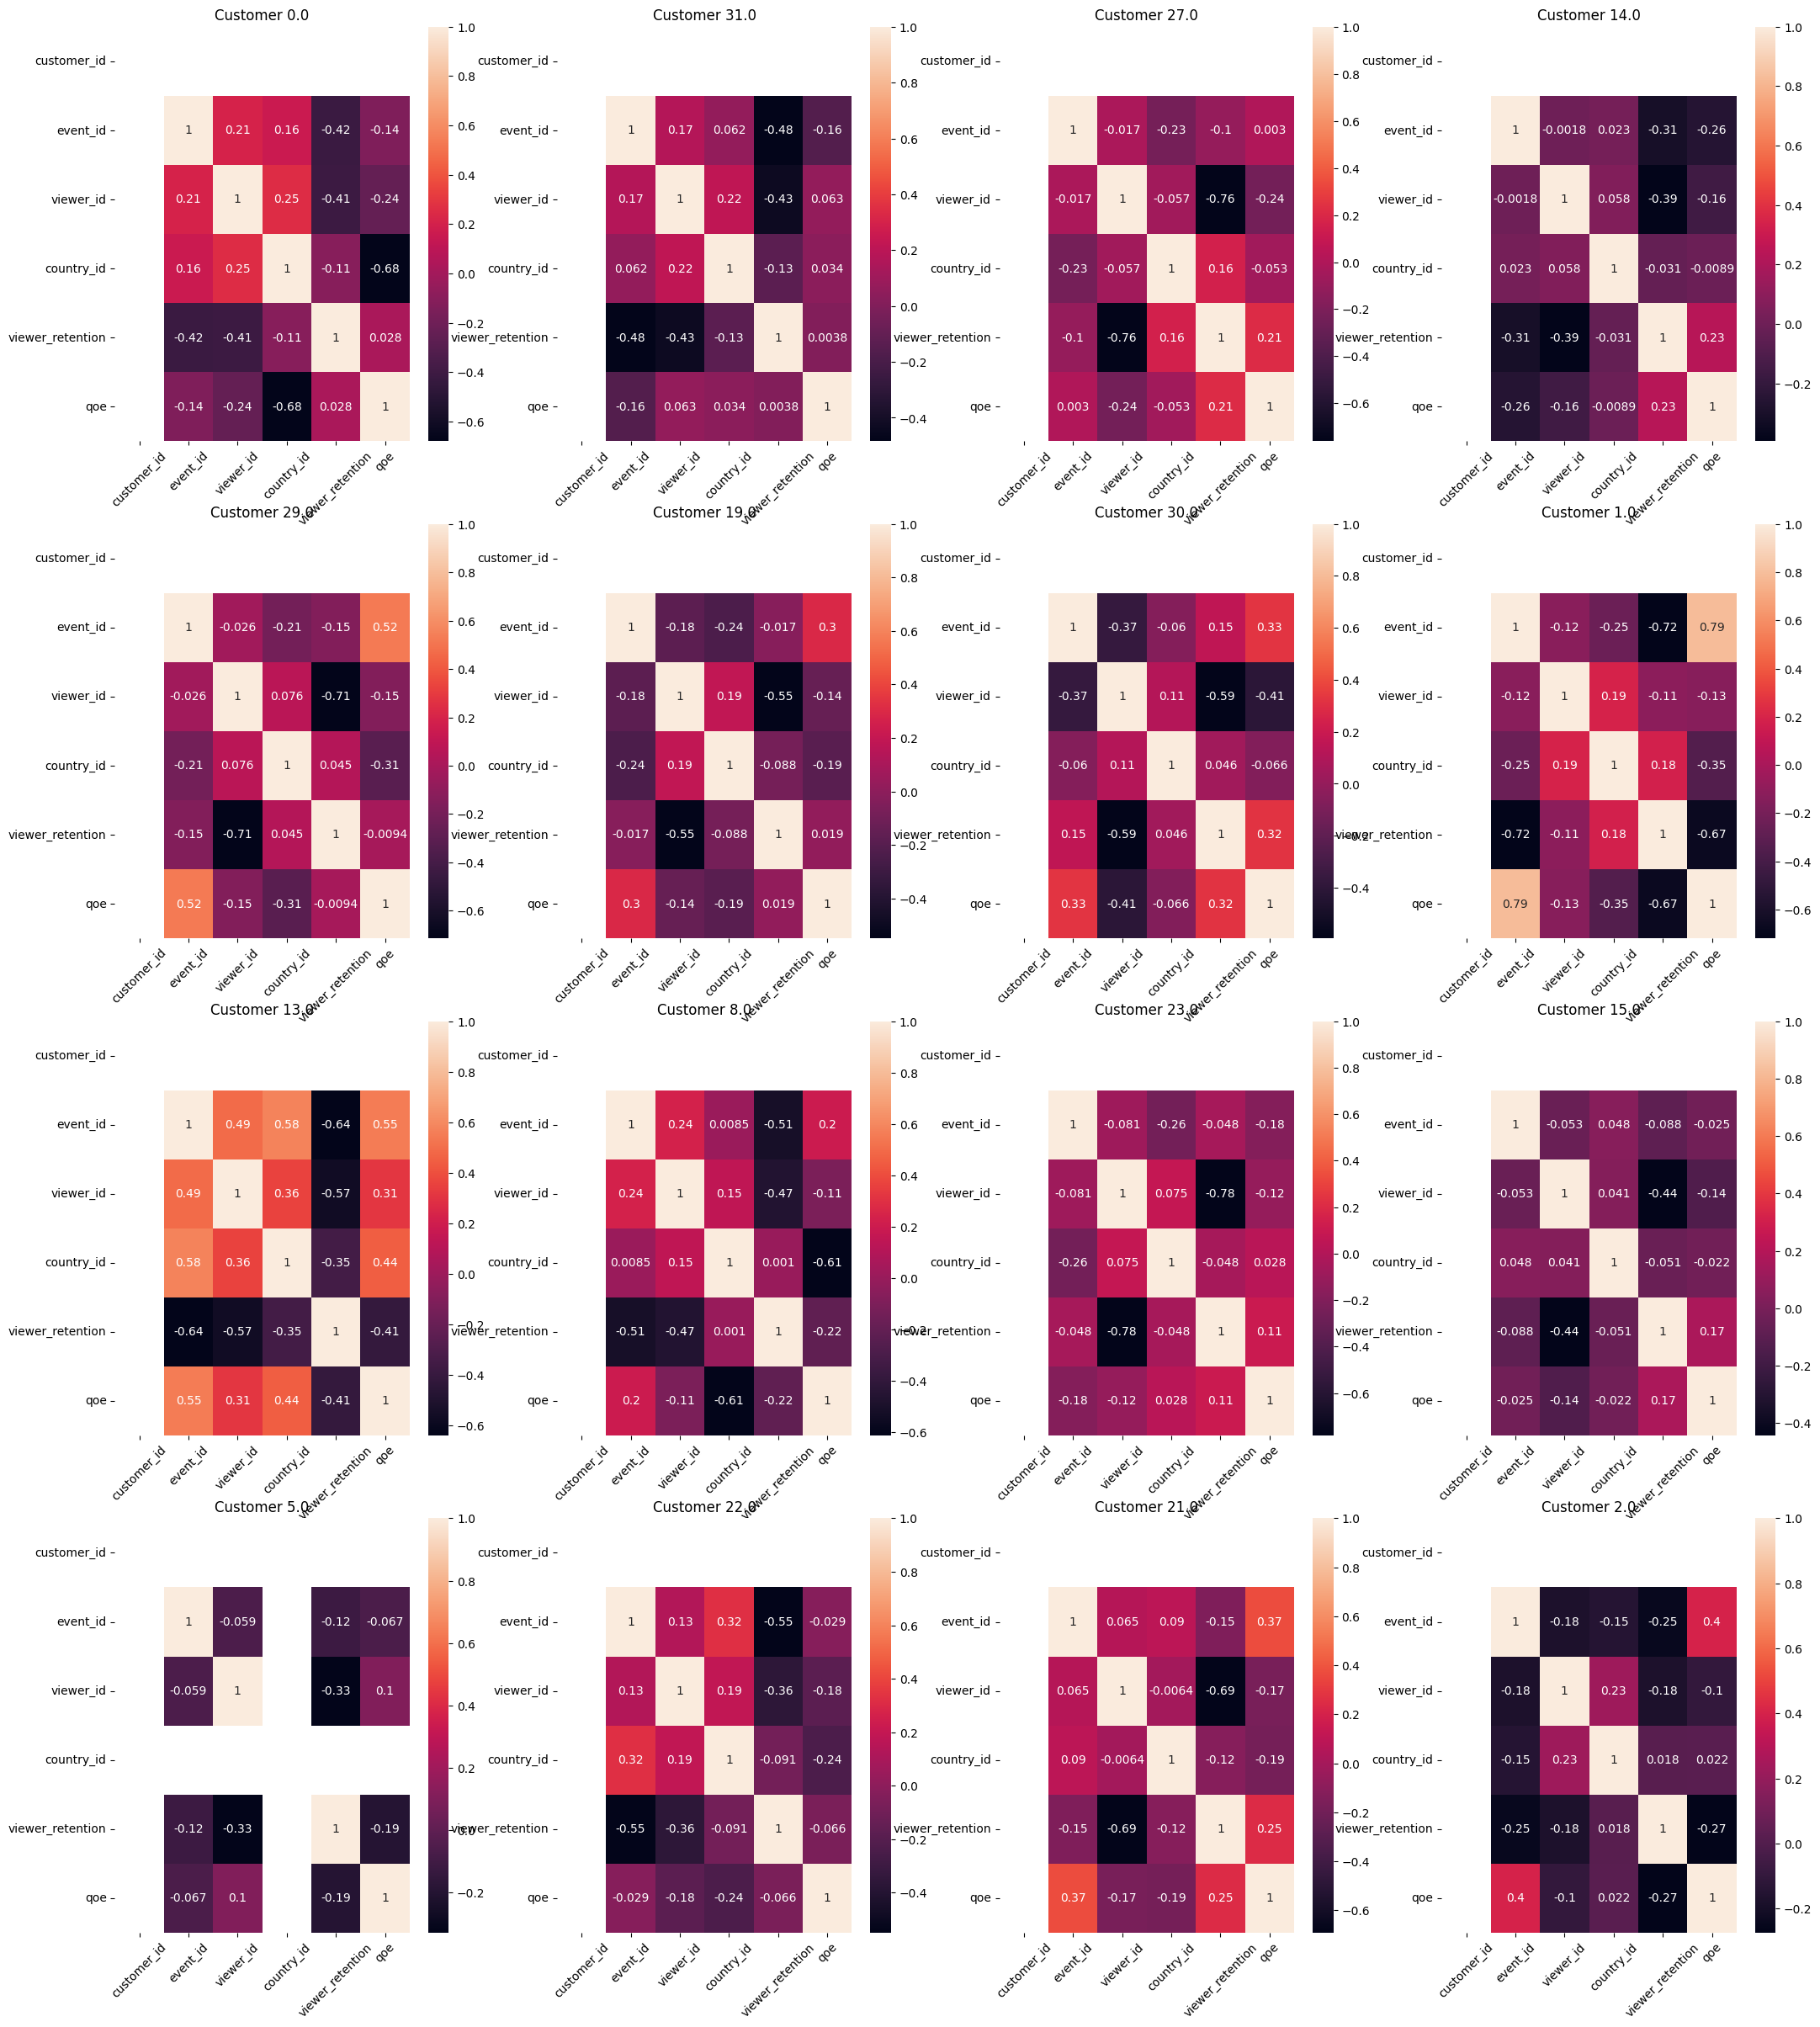

In [12]:
df8 = df.copy()
df9 = df2[["customer_id", "event_id", "qoe"]]
df8.drop(["buffer_ms", "engagement", "qoe",
            "city_id"], axis=1, inplace=True)

max_timestamp_df = df8.groupby(["customer_id", "event_id", "viewer_id"])[
    "timestamp"].max().to_frame("max").reset_index()
min_timestamp_df = df8.groupby(["customer_id", "event_id", "viewer_id"])[
    "timestamp"].min().to_frame("min").reset_index()
duration = (max_timestamp_df["max"].to_numpy() -
            min_timestamp_df["min"].to_numpy())

df8.drop_duplicates(["customer_id", "event_id", "viewer_id"], inplace=True)
df8["viewer_retention"] = duration
df8["viewer_retention"] = df8["viewer_retention"].apply(
    lambda x: x.total_seconds() / 60)
df8.drop(["timestamp"], axis=1, inplace=True)
df8 = df8.merge(df9, on=["customer_id", "event_id"])

i, j = 0, 0

figure, axis = plt.subplots(4, 4)
figure.set_size_inches(26, 30)
for customer_id in df3["customer_id"].values:

    target_customer = df8.iloc[np.where(df8["customer_id"] == customer_id)]
    sns.heatmap(target_customer.corr(method="pearson"),
                annot=True, ax=axis[i, j])
    axis[i, j].set_title("Customer {}".format(customer_id))
    axis[i, j].xaxis.set_visible(True)
    axis[i, j].yaxis.set_visible(True)
    for tick in axis[i, j].get_xticklabels():

        tick.set_rotation(45)

    i = i + 1
    if i == 4:
        i = 0
        j = j + 1
